# Описание хода работы

Импортим нужные библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import plotly.graph_objs as go
import missingno as msn
from fancyimpute import KNN
import warnings

warnings.filterwarnings("ignore")

Загружаем данные и делаем предобрабку и избавляем отсутствующие значения. Также разбивая датасет на 2 части.

In [2]:
train_data = pd.read_csv("../merged_data_without_links.csv")

# Предобработка данных
def preprocess_data(df):
    df = df.drop(columns='report_date', errors='ignore')
    df = df.loc[:, df.isnull().mean() < 0.8]
    df_target_0 = df[df['target'] == 0]
    df_target_1 = df[df['target'] == 1]
    return df_target_0, df_target_1

Переводим дату в формат datetime и убираем все нечисловые столбцы. Заполняем пропуски нулями

In [3]:
train_data["report_date"] = pd.to_datetime(train_data["report_date"], format="%Y-%m-%d")
train_data = train_data.select_dtypes(exclude=["object"])
train_data = train_data.fillna(0)
df_target_0, df_target_1 = preprocess_data(train_data)

Проверями имеющиеся данные на предмет наличия пропусков и построим график.

<Axes: >

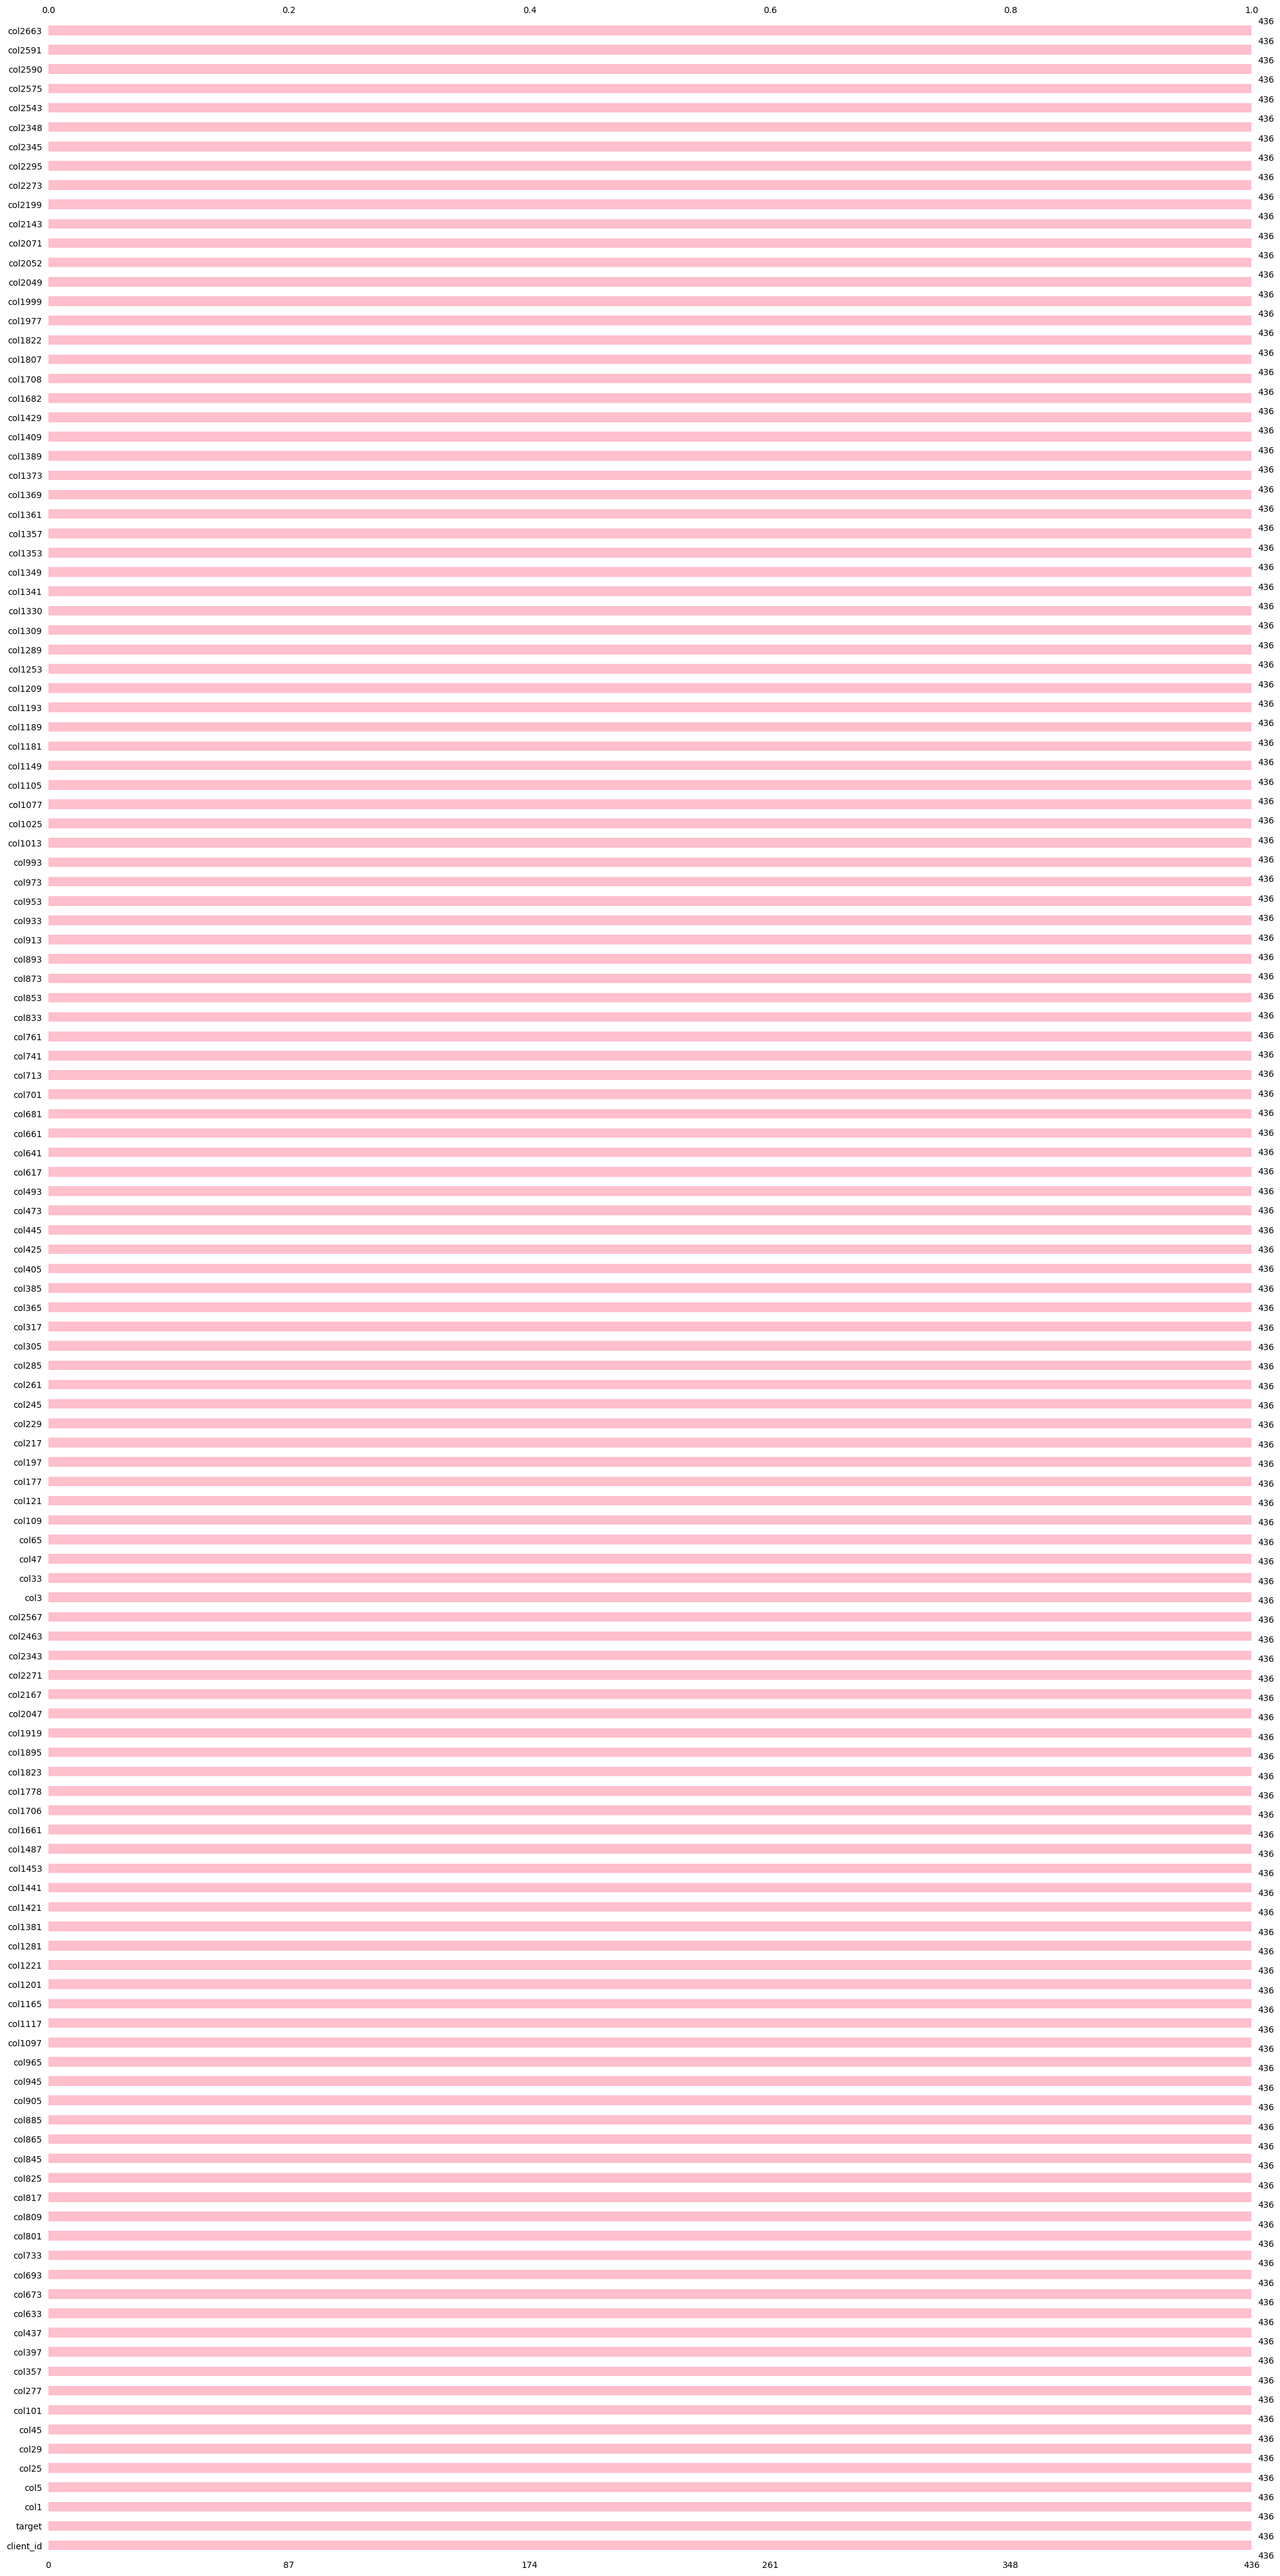

In [4]:
msn.bar(df_target_1, fontsize=10, color=(1, 0.75, 0.8))

Заполнение пропусков с использованием KNN

In [5]:
df_filled_0 = pd.DataFrame(KNN(k=9).fit_transform(df_target_0), columns=df_target_0.columns)
df_filled_1 = pd.DataFrame(KNN(k=9).fit_transform(df_target_1), columns=df_target_1.columns)
df_combined = pd.concat([df_filled_0, df_filled_1])

c:\Users\Виктор\AppData\Local\Programs\Python\Python312\Lib\site-packages\fancyimpute\solver.py:55: UserWarning: Input matrix is not missing any values
  warnings.warn("Input matrix is not missing any values")
c:\Users\Виктор\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Виктор\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Imputing row 1/14020 with 0 missing, elapsed time: 69.975
Imputing row 101/14020 with 0 missing, elapsed time: 69.975
Imputing row 201/14020 with 0 missing, elapsed time: 69.975
Imputing row 301/14020 with 0 missing, elapsed time: 69.975
Imputing row 401/14020 with 0 missing, elapsed time: 69.975
Imputing row 501/14020 with 0 missing, elapsed time: 69.975
Imputing row 601/14020 with 0 missing, elapsed time: 69.975
Imputing row 701/14020 with 0 missing, elapsed time: 69.975
Imputing row 801/14020 with 0 missing, elapsed time: 69.975
Imputing row 901/14020 with 0 missing, elapsed time: 69.976
Imputing row 1001/14020 with 0 missing, elapsed time: 69.976
Imputing row 1101/14020 with 0 missing, elapsed time: 69.976
Imputing row 1201/14020 with 0 missing, elapsed time: 69.976
Imputing row 1301/14020 with 0 missing, elapsed time: 69.976
Imputing row 1401/14020 with 0 missing, elapsed time: 69.976
Imputing row 1501/14020 with 0 missing, elapsed time: 69.976
Imputing row 1601/14020 with 0 missi

c:\Users\Виктор\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Виктор\AppData\Local\Programs\Python\Python312\Lib\site-packages\fancyimpute\solver.py:55: UserWarning: Input matrix is not missing any values
  warnings.warn("Input matrix is not missing any values")
c:\Users\Виктор\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Виктор\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Нормализация данных. Разделение данных на обучающую и тестовую выборки

In [7]:
# Разделение данных на признаки (X) и целевую переменную (y)
X = df_combined.drop(columns='target')
y = df_combined['target']

scaler = StandardScaler()
X = scaler.fit_transform(X)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

c:\Users\Виктор\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Виктор\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Обучение модели

In [8]:
rf_model = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)

auc = metrics.roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.3f}")

AUC: 0.789


Построение ROC-кривой с использованием matplotlib

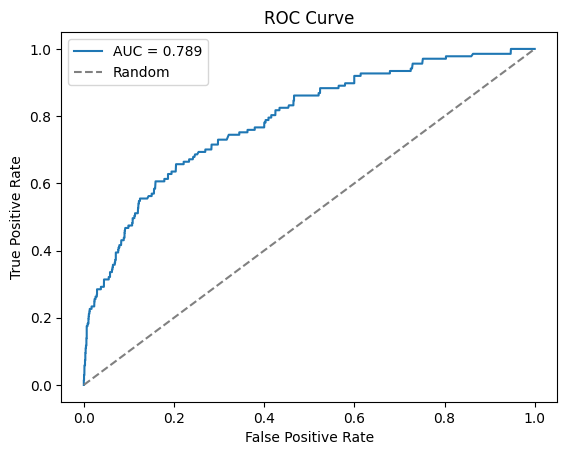

In [9]:
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Построение интерактивной ROC-кривой с использованием plotly

In [10]:
# Интерактивная ROC-кривая
trace = go.Scatter(x=fpr, y=tpr, mode='lines', name=f'AUC = {auc:.2f}',
                   line=dict(color='darkorange', width=2))
reference_line = go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Reference Line',
                            line=dict(color='navy', width=2, dash='dash'))
fig = go.Figure(data=[trace, reference_line])
fig.update_layout(title='Interactive ROC Curve',
                  xaxis_title='False Positive Rate',
                  yaxis_title='True Positive Rate')
fig.show()